In [1]:
%load_ext autoreload
%autoreload 2

## Basic imports

In [2]:
import pandas as pd
import numpy as np

### Graphql imports

In [3]:
import asyncio

from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport

### Visualisation imports

In [4]:
# import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Read data

In [5]:
url = "https://public-api.defiyield.app/graphql/"
header = {"X-Api-Key": "bad7014e-3fd4-473a-b981-1a5c2dd2d72e"}

rekt_query_str = """
        query {
            rekts(
                orderBy: {
                fundsLost: desc
                }
            ) {
                id, 
                projectName, 
                date, 
                description,
                fundsLost, 
                fundsReturned,
                category, 
                issueType,
                chaindIds,
                token{
                  name
                }
            }
        }
        """

chains_query_str = """
        query {
            chains {
                id,
                absoluteChainId,
                abbr,
                name,
                type
            }
        }
        """

In [6]:
async def get_data(query_str):

    transport = AIOHTTPTransport(url=url, headers=header)

    # Using `async with` on the client will start a connection on the transport
    # and provide a `session` variable to execute queries on this connection
    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:

        # Execute single query
        query = gql(query_str)
        return await session.execute(query)


rekt_df = await get_data(rekt_query_str)
rekt_df = pd.DataFrame(rekt_df['rekts'])

chains_df = await get_data(chains_query_str)
chains_df = pd.DataFrame(chains_df['chains']).set_index('id')

## Clean data

In [7]:
# rekt_df = pd.DataFrame(result['rekts'], dtype={'fundsLost': 'float'})
rekt_df['fundsLost'] = pd.to_numeric(rekt_df['fundsLost'])
rekt_df['fundsReturned'] = pd.to_numeric(rekt_df['fundsReturned'])
rekt_df['date'] = pd.to_datetime(rekt_df['date'])

rekt_df['chaindId'] = rekt_df['chaindIds'].apply(lambda x: None if len(x) == 0 else x[0])
rekt_df['tokenName'] = rekt_df['token'].apply(lambda x: None if x['name'] == None else x['name'].split(',')[0])

## Merge dataframes

In [8]:
final_df = pd.merge(rekt_df, chains_df[['name']].rename(columns={'name': 'chainName'}), left_on=['chaindId'], right_index=True)
final_df.head()

,id,projectName,date,description,fundsLost,fundsReturned,category,issueType,chaindIds,token,chaindId,tokenName,chainName
0,3058,Terra Classic,2022-05-08,<p><strong>Quick Summary</strong></p><p>A comp...,40000000000,0,Stablecoin,Other,[22],"{'name': 'LUNC, USTC'}",22.0,LUNC,cardano
42,3030,Mirror Protocol,2021-10-08,<p><strong>Quick Summary</strong></p><p>Terra'...,90000000,0,"Borrowing and Lending,Other",Other,[22],{'name': 'MIR'},22.0,MIR,cardano
15,2543,Poly Network,2021-08-10,<p><strong>Quick Summary</strong></p><p><span ...,602189570,602189570,Other,Other,[1],{'name': None},1.0,None,ethereum
24,3112,Nomad,2022-08-01,<p><strong>Quick Summary</strong><br>The Nomad...,190000000,36342325,Bridge,Other,[1],{'name': 'Nomad: ERC20 Bridge'},1.0,Nomad: ERC20 Bridge,ethereum
25,2991,Beanstalk,2022-04-18,<p><strong>Quick Summary</strong>&nbsp;</p><p>...,181000000,0,Stablecoin,Flash Loan Attack,[1],{'name': 'BEAN'},1.0,BEAN,ethereum


## Visualisation

### Cumulative Lost Funds

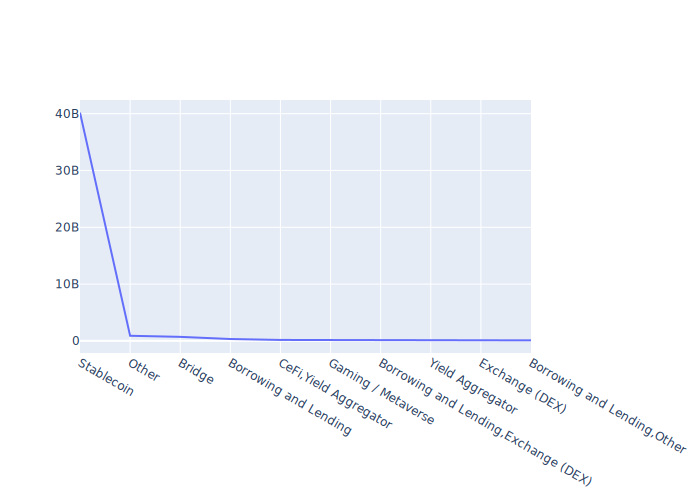

In [12]:
groupby_col = 'category'

mask = final_df['date'] >= '2022-01-01'
# grouped = df[mask].groupby(groupby_col)[['fundsLost', 'fundsReturned']].sum()
grouped = final_df.groupby(groupby_col)[['fundsLost', 'fundsReturned']].sum()

grouped.sort_values(by='fundsLost', ascending=False, inplace=True)
fig = go.Figure()
fig.add_trace(go.Scatter(x=grouped.index, y=grouped['fundsLost'],
                    mode='lines',
                    name='fundsLost'))

fig.show("svg")